## ***Assignment 2***

In [22]:
import torch
import numpy as np
torch.cuda.empty_cache()

#### ***Import neccessary libraries and load the ratings***

In [5]:
import pandas as pd

# Cargar el archivo ratings.csv
ratings = pd.read_csv('../data/ml-latest-small/ratings.csv')

# Ver las primeras filas
print(ratings.head())

# Revisar tamaño y columnas
print(ratings.shape)
print(ratings.columns)

   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931
(100836, 4)
Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')


#### ***Preproccessing***

In [6]:
# Filtrar usuarios con menos de 10 ratings
user_counts = ratings['userId'].value_counts()
ratings = ratings[ratings['userId'].isin(user_counts[user_counts >= 10].index)]

# Filtrar películas con menos de 10 ratings
movie_counts = ratings['movieId'].value_counts()
ratings = ratings[ratings['movieId'].isin(movie_counts[movie_counts >= 10].index)]

print(f"Usuarios después de filtrar: {ratings['userId'].nunique()}")
print(f"Películas después de filtrar: {ratings['movieId'].nunique()}")

Usuarios después de filtrar: 610
Películas después de filtrar: 2269


In [7]:
# Obtener IDs únicos
unique_user_ids = ratings['userId'].unique()
unique_movie_ids = ratings['movieId'].unique()

print(f"Número de usuarios únicos: {len(unique_user_ids)}")
print(f"Número de películas únicas: {len(unique_movie_ids)}")

# Crear diccionarios de mapeo
userId_to_index = {user_id: idx for idx, user_id in enumerate(unique_user_ids)}
movieId_to_index = {movie_id: idx for idx, movie_id in enumerate(unique_movie_ids)}

# Aplicar el mapeo al DataFrame
ratings['userIndex'] = ratings['userId'].map(userId_to_index)
ratings['movieIndex'] = ratings['movieId'].map(movieId_to_index)

# Comprobar
print(ratings.head())

Número de usuarios únicos: 610
Número de películas únicas: 2269
   userId  movieId  rating  timestamp  userIndex  movieIndex
0       1        1     4.0  964982703          0           0
1       1        3     4.0  964981247          0           1
2       1        6     4.0  964982224          0           2
3       1       47     5.0  964983815          0           3
4       1       50     5.0  964982931          0           4


In [8]:
# Normalizamos ratings a [0, 1]
ratings['rating_norm'] = ratings['rating'] / 5.0
print(ratings[['rating', 'rating_norm']].head())

   rating  rating_norm
0     4.0          0.8
1     4.0          0.8
2     4.0          0.8
3     5.0          1.0
4     5.0          1.0


#### ***Split and Prepare***

In [9]:
from sklearn.model_selection import train_test_split

# Primero filtramos usuarios con al menos 3 ratings
user_counts = ratings['userId'].value_counts()
ratings_filtered = ratings[ratings['userId'].isin(user_counts[user_counts >= 3].index)]

# Luego aplicamos el split
train_list = []
val_list = []
test_list = []

for user_id, group in ratings_filtered.groupby('userId'):
    user_train, user_temp = train_test_split(group, test_size=0.30, random_state=42)
    user_val, user_test = train_test_split(user_temp, test_size=0.50, random_state=42)
    
    train_list.append(user_train)
    val_list.append(user_val)
    test_list.append(user_test)

train_data = pd.concat(train_list).reset_index(drop=True)
val_data = pd.concat(val_list).reset_index(drop=True)
test_data = pd.concat(test_list).reset_index(drop=True)

print(f"Train size: {len(train_data)}")
print(f"Validation size: {len(val_data)}")
print(f"Test size: {len(test_data)}")

Train size: 56505
Validation size: 12164
Test size: 12447


#### ***Dataloaders***

In [10]:
import torch
from torch.utils.data import Dataset, DataLoader

# Convertir a tensores los índices de usuario, película y ratings
train_user = torch.tensor(train_data['userIndex'].values, dtype=torch.long)
train_movie = torch.tensor(train_data['movieIndex'].values, dtype=torch.long)
train_rating = torch.tensor(train_data['rating_norm'].values, dtype=torch.float32)

val_user = torch.tensor(val_data['userIndex'].values, dtype=torch.long)
val_movie = torch.tensor(val_data['movieIndex'].values, dtype=torch.long)
val_rating = torch.tensor(val_data['rating_norm'].values, dtype=torch.float32)

test_user = torch.tensor(test_data['userIndex'].values, dtype=torch.long)
test_movie = torch.tensor(test_data['movieIndex'].values, dtype=torch.long)
test_rating = torch.tensor(test_data['rating_norm'].values, dtype=torch.float32)

#### ***Dataset Personalizado***

In [11]:
class MovieLensDataset(Dataset):
    def __init__(self, users, movies, ratings):
        self.users = users
        self.movies = movies
        self.ratings = ratings

    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, idx):
        return {
            'user': self.users[idx],
            'movie': self.movies[idx],
            'rating': self.ratings[idx]
        }

#### ***Dataloaders***

In [12]:
batch_size = 512

train_dataset = MovieLensDataset(train_user, train_movie, train_rating)
val_dataset = MovieLensDataset(val_user, val_movie, val_rating)
test_dataset = MovieLensDataset(test_user, test_movie, test_rating)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

#### ***Simple Model***

In [13]:
import torch.nn as nn
import torch.nn.functional as F

class NeuralCollaborativeFiltering(nn.Module):
    def __init__(self, num_users, num_movies, embedding_dim=64, dropout_rate=0.3):
        super(NeuralCollaborativeFiltering, self).__init__()
        
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.movie_embedding = nn.Embedding(num_movies, embedding_dim)
        
        # MLP con Dropout
        self.fc1 = nn.Linear(embedding_dim * 2, 128)
        self.fc2 = nn.Linear(128, 64)
        self.output_layer = nn.Linear(64, 1)
        
        self.dropout = nn.Dropout(dropout_rate)
        
    def forward(self, user, movie):
        user_embedded = self.user_embedding(user)
        movie_embedded = self.movie_embedding(movie)
        
        x = torch.cat([user_embedded, movie_embedded], dim=1)
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        out = self.output_layer(x)
        
        return out.squeeze()

#### ***Optimizer***

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando dispositivo: {device}")

Usando dispositivo: cuda


In [15]:
num_users = len(userId_to_index)
num_movies = len(movieId_to_index)

model = NeuralCollaborativeFiltering(num_users=num_users, num_movies=num_movies).to(device)
print("Modelo con Dropout creado correctamente")

Modelo con Dropout creado correctamente


In [16]:
import torch.optim as optim
import torch.nn as nn

criterion = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-5)

#### ***Trainning***

In [17]:
num_epochs = 10  # Puedes ajustar luego

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch in train_loader:
        users = batch['user'].to(device)
        movies = batch['movie'].to(device)
        ratings = batch['rating'].to(device)  # ← ya es rating_norm

        preds = model(users, movies)
        loss = criterion(preds, ratings)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * len(ratings)

    avg_train_loss = total_loss / len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            users = batch['user'].to(device)
            movies = batch['movie'].to(device)
            ratings = batch['rating'].to(device)

            preds = model(users, movies)
            loss = criterion(preds, ratings)
            val_loss += loss.item() * len(ratings)

    avg_val_loss = val_loss / len(val_loader.dataset)

    print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")

Epoch 1: Train Loss = 0.0861, Val Loss = 0.0408
Epoch 2: Train Loss = 0.0509, Val Loss = 0.0385
Epoch 3: Train Loss = 0.0469, Val Loss = 0.0373
Epoch 4: Train Loss = 0.0444, Val Loss = 0.0366
Epoch 5: Train Loss = 0.0426, Val Loss = 0.0355
Epoch 6: Train Loss = 0.0412, Val Loss = 0.0352
Epoch 7: Train Loss = 0.0404, Val Loss = 0.0345
Epoch 8: Train Loss = 0.0396, Val Loss = 0.0344
Epoch 9: Train Loss = 0.0385, Val Loss = 0.0341
Epoch 10: Train Loss = 0.0379, Val Loss = 0.0337


In [19]:
torch.save(model.state_dict(), "../models/solo_rantings.pth")
print("Modelo guardado correctamente.")

Modelo guardado correctamente.


#### ***Model evaluation***

##### ***RMSE***

In [23]:
all_preds = []
all_truth = []

model.eval()
with torch.no_grad():
    for batch in test_loader:
        users = batch['user'].to(device, dtype=torch.long)
        movies = batch['movie'].to(device, dtype=torch.long)
        ratings = batch['rating'].to(device, dtype=torch.float)  # Asumo ratings como float
        
        preds = model(users, movies)
        
        # Desnormalización (si ratings/preds están en 0-1)
        all_preds.extend((preds * 5).cpu().numpy())
        all_truth.extend((ratings * 5).cpu().numpy())

all_preds = np.array(all_preds)
all_truth = np.array(all_truth)

rmse = np.sqrt(np.mean((all_preds - all_truth) ** 2))

##### ***MAE***

In [24]:
mae = np.mean(np.abs(all_preds - all_truth))

#### ***R-Square***

In [25]:
from sklearn.metrics import r2_score
r2 = r2_score(all_truth, all_preds)

#### ***Precision***

In [26]:
from collections import defaultdict

k = 10
user_preds = defaultdict(list)
user_truth = defaultdict(list)

model.eval()
with torch.no_grad():
    for batch in test_loader:
        users = batch['user'].to(device, dtype=torch.long)
        movies = batch['movie'].to(device, dtype=torch.long)
        ratings = batch['rating'].to(device, dtype=torch.float)
        
        preds = model(users, movies)
        
        # Desnormalizamos a escala 0.5 - 5
        preds = preds * 5
        ratings = ratings * 5
        
        for u, pred, true in zip(users.cpu().numpy(), preds.cpu().numpy(), ratings.cpu().numpy()):
            user_preds[u].append(pred)
            user_truth[u].append(true)

# Calculamos Precision@K
precisions = []
for u in user_preds:
    preds_u = np.array(user_preds[u])
    truths_u = np.array(user_truth[u])
    
    # Ordenar por predicción descendente y coger top K
    top_k_indices = np.argsort(-preds_u)[:k]
    
    # Definir relevantes: ratings reales >= 4.0
    relevant = (truths_u >= 4.0)
    num_relevant = np.sum(relevant[top_k_indices])
    
    precision_u = num_relevant / k
    precisions.append(precision_u)

precision_at_k = np.mean(precisions)

#### ***NDCG@K***

In [27]:
def ndcg_at_k(relevances, k):
    relevances = np.asarray(relevances)[:k]
    if relevances.size == 0:
        return 0.0
    # DCG: (2^rel - 1) / log2(pos + 1)
    dcg = np.sum((2 ** relevances - 1) / np.log2(np.arange(2, relevances.size + 2)))
    
    # Ideal DCG: orden perfecto
    ideal_relevances = np.sort(relevances)[::-1]
    idcg = np.sum((2 ** ideal_relevances - 1) / np.log2(np.arange(2, ideal_relevances.size + 2)))
    
    return dcg / idcg if idcg > 0 else 0.0

# Calculamos NDCG@K para cada usuario
ndcgs = []
for u in user_preds:
    preds_u = np.array(user_preds[u])
    truths_u = np.array(user_truth[u])
    
    # Relevancia binaria: 1 si rating real >= 4.0, 0 en caso contrario
    relevances = (truths_u >= 4.0).astype(int)
    
    # Ordenar por predicción descendente y coger top-K
    top_k_indices = np.argsort(-preds_u)[:k]
    
    ndcg_u = ndcg_at_k(relevances[top_k_indices], k)
    ndcgs.append(ndcg_u)

# Media total
ndcg_at_k_value = np.mean(ndcgs)

#### ***All Metrics***

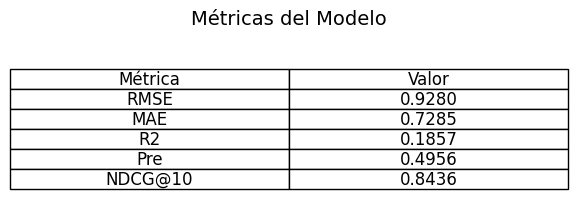

In [31]:
from tabulate import tabulate

# Suponiendo que ya tienes las variables calculadas:
# rmse, mae, r2, precision_at_k, ndcg_at_k_value

# Aseguramos que todos los valores sean Python floats y estén redondeados
metrics = {
    'RMSE': float(np.round(rmse, 4)),
    'MAE': float(np.round(mae, 4)),
    'R2': float(np.round(r2, 4)),
    'Pre': float(np.round(precision_at_k, 4)),
    'NDCG@10': float(np.round(ndcg_at_k_value, 4))
}

# Crear un DataFrame
metrics_df = pd.DataFrame(list(metrics.items()), columns=['Métrica', 'Valor'])

# Alternativa: formatear explícitamente los valores en el DataFrame
metrics_df['Valor'] = metrics_df['Valor'].apply(lambda x: f"{x:.4f}")

import matplotlib.pyplot as plt

# Creamos figura y eje
fig, ax = plt.subplots(figsize=(6, 2))

# Ocultamos los ejes
ax.axis('off')

# Creamos la tabla visualmente
table = ax.table(cellText=metrics_df.values,
                 colLabels=metrics_df.columns,
                 loc='center',
                 cellLoc='center')

# Ajustes estéticos
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)

plt.title("Métricas del Modelo", fontsize=14, pad=20)
plt.show()